In [1]:
import torch
import numpy as np
import pandas as pd

# Loading and Cleaning-up Data

In [2]:
df = pd.read_csv("data/train.csv")
df.set_index("PassengerId", inplace=True)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [4]:
# We are going to fill missing values with the mode of each column.
# Pandas has a built-in method to calculate the mode, but it return more than one value if there a tie.
# We take the first mode in case of ties.
modes = df.mode().iloc[0]
modes

Survived                    0.0
Pclass                      3.0
Name        Abbing, Mr. Anthony
Sex                        male
Age                        24.0
SibSp                       0.0
Parch                       0.0
Ticket                     1601
Fare                       8.05
Cabin                   B96 B98
Embarked                      S
Name: 0, dtype: object

In [5]:
df.fillna(modes, inplace=True)

In [6]:
df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [7]:
df.describe(include=(np.number))

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

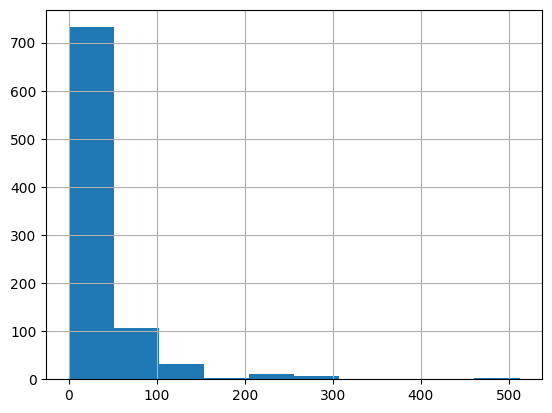

In [8]:
df.Fare.hist()

In [9]:
# Long-tailed distribution does not work well with neural networks.
# We can use a log transformation to make it more normal.
# Since sometimes Fare can be zero, we use log1p to avoid issues with log(0).
df["LogFare"] = np.log1p(df["Fare"])

<Axes: >

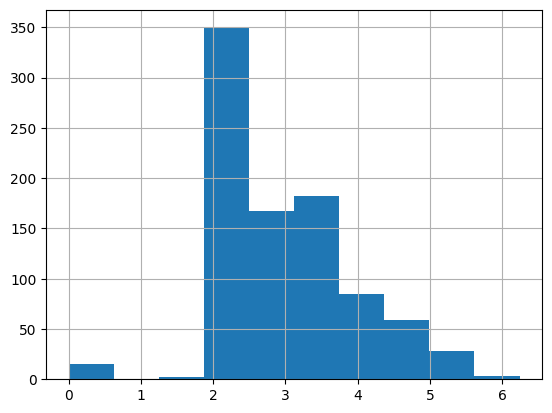

In [10]:
df.LogFare.hist()

In [11]:
df.Pclass.unique()

array([3, 1, 2])

In [12]:
df.describe(include="object")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [13]:
# Clearly we can't multiply strings like male or S by coefficients, so we need to replace those with numbers.
# Apply one-hot encoding to categorical variables and remove the original columns.
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"], dtype=np.float32)
df.columns

Index(['Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [14]:
added_cols = [
    "Sex_male",
    "Sex_female",
    "Pclass_1",
    "Pclass_2",
    "Pclass_3",
    "Embarked_C",
    "Embarked_Q",
    "Embarked_S",
]
indep_cols = [
    "Age",
    "SibSp",
    "Parch",
    "LogFare",
] + added_cols
df[indep_cols].head()

,Age,SibSp,Parch,LogFare,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1,22.0,1,0,2.110213,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,38.0,1,0,4.280593,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,26.0,0,0,2.188856,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,35.0,1,0,3.990834,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,35.0,0,0,2.202765,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [15]:
# Create dependent and independent variables.
Y = torch.tensor(df.Survived.values)
X = torch.tensor(
    df[indep_cols].values, dtype=torch.float
)  # .values returns a numpy array.

In [16]:
X.shape, Y.shape

(torch.Size([891, 12]), torch.Size([891]))

In [17]:
# Normalize the independent variables.
X_mean = X.mean(dim=0)
X_std = X.std(dim=0)
X = (X - X_mean) / X_std
X[:5]

tensor([[-0.4975,  0.4326, -0.4734, -0.8792,  0.7373, -0.7373, -0.5654, -0.5099,
          0.9021, -0.4818, -0.3074,  0.6155],
        [ 0.7146,  0.4326, -0.4734,  1.3605, -1.3548,  1.3548,  1.7668, -0.5099,
         -1.1073,  2.0733, -0.3074, -1.6229],
        [-0.1945, -0.4743, -0.4734, -0.7981, -1.3548,  1.3548, -0.5654, -0.5099,
          0.9021, -0.4818, -0.3074,  0.6155],
        [ 0.4874,  0.4326, -0.4734,  1.0614, -1.3548,  1.3548,  1.7668, -0.5099,
         -1.1073, -0.4818, -0.3074,  0.6155],
        [ 0.4874, -0.4743, -0.4734, -0.7837,  0.7373, -0.7373, -0.5654, -0.5099,
          0.9021, -0.4818, -0.3074,  0.6155]])

# One Epoch Example

In [18]:
# Linear model takes every feature and multiple it by a coefficient.
# Let's start from a random coefficient for each feature.
torch.manual_seed(442)
n_coeff = X.shape[1]
n_coeff

12

In [19]:
coeffs = (
    torch.rand(
        n_coeff,
        dtype=torch.float,
    )
    - 0.5
)  # Random coefficients in the range [-0.5, 0.5]
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625])

In [20]:
# Our predictions will be calculated by multiplying each row by the coefficients, and adding them up.
# Of course, these predictions aren't going to be any use, since our coefficients are random -
# they're just a starting point for our gradient descent process.
preds = X @ coeffs
print(len(preds), preds[:10])

891 tensor([ 0.6000, -1.9341,  0.2080,  0.1723, -0.0032,  0.3088, -0.5066,  1.6219,
         0.6990, -1.2584])


In [21]:
# To do gradient descent, we need a loss function.
# Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent)
# is generally a reasonable approach.
loss = torch.abs(preds - Y).mean()
loss

tensor(0.8891)

In [22]:
Y[:10]

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [23]:
def calc_preds(coeffs, indeps):
    return indeps @ coeffs


def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

In [24]:
# To get PyTorch to calculate gradients, we'll need to call requires_grad_() on our coeffs
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [25]:
loss = calc_loss(coeffs, X, Y)
loss

tensor(0.8891, grad_fn=<MeanBackward0>)

In [26]:
# Use backward() to ask PyTorch to calculate gradients now:
loss.backward()

In [27]:
coeffs.grad

tensor([-0.4181,  0.1828,  0.1708, -0.2654,  0.2976, -0.2976, -0.3301, -0.0329,
         0.3112, -0.4553,  0.0369,  0.3756])

In [28]:
# Note that each time we call backward, the gradients are actually added to whatever is in the .grad attribute.
# For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, X, Y))

tensor(0.7882)


The one step of gradient, indeed, decreased the loss!

# Train Linear Model

In [29]:
from fastai.data.transforms import RandomSplitter

trn_split, val_split = RandomSplitter(seed=42)(df)

In [30]:
trn_indep, val_indep = X[trn_split], X[val_split]
trn_dep, val_dep = Y[trn_split], Y[val_split]
len(trn_indep), len(val_indep)

(713, 178)

In [31]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [32]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, X, Y)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [33]:
def init_coeffs():
    return (torch.rand(n_coeff) - 0.5).requires_grad_()

In [34]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr=lr)
    return coeffs

In [35]:
coeffs = train_model(lr=0.2)

0.889; 0.697; 0.590; 0.529; 0.496; 0.476; 0.463; 0.453; 0.444; 0.438; 0.431; 0.424; 0.419; 0.412; 0.406; 0.402; 0.398; 0.412; 0.439; 0.424; 0.406; 0.403; 0.406; 0.428; 0.426; 0.407; 0.407; 0.419; 0.404; 0.413; 

In [36]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))


show_coeffs()

{'Age': tensor(0.0108),
 'SibSp': tensor(-0.0226),
 'Parch': tensor(-0.0143),
 'LogFare': tensor(0.0553),
 'Sex_male': tensor(-0.3315),
 'Sex_female': tensor(-0.2465),
 'Pclass_1': tensor(0.3881),
 'Pclass_2': tensor(0.3459),
 'Pclass_3': tensor(0.3393),
 'Embarked_C': tensor(0.0631),
 'Embarked_Q': tensor(0.0410),
 'Embarked_S': tensor(0.0291)}

# A neural network

In [39]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5) / n_hidden
    layer2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [40]:
import torch.nn.functional as F


def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs
    res = F.relu(indeps @ l1)
    res = res @ l2 + const
    return torch.sigmoid(res)

In [41]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [45]:
coeffs = train_model(lr=1.4)

0.545; 0.539; 0.534; 0.530; 0.525; 0.520; 0.515; 0.510; 0.505; 0.499; 0.494; 0.488; 0.483; 0.477; 0.472; 0.466; 0.461; 0.456; 0.452; 0.447; 0.443; 0.439; 0.436; 0.433; 0.429; 0.427; 0.424; 0.422; 0.419; 0.417; 

In [46]:
coeffs = train_model(lr=20)

0.545; 0.514; 0.428; 0.398; 0.393; 0.390; 0.389; 0.388; 0.387; 0.386; 0.386; 0.386; 0.386; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.384; 0.384; 0.384; 0.384; 0.384; 0.384; 

In [47]:
coeffs

(tensor([[ 8.9836e-07, -2.3060e-05,  1.5718e-05, -1.0140e-01, -2.8943e-01,
           6.9720e-05, -2.8872e-05, -1.5632e-05,  2.0677e-05,  5.6258e-05,
           1.9656e-05, -6.9791e-02,  8.9572e-03,  1.8992e-05, -4.0221e-02,
           1.6677e-02,  1.1462e-05,  2.6156e-04,  1.3494e-04,  2.3525e-01],
         [ 1.0394e-04, -2.6668e-04,  1.1940e-03, -1.0961e-01,  2.5292e-01,
          -4.1498e-03,  8.7632e-05,  8.7965e-05,  2.2892e-04,  5.6902e-05,
          -2.1537e-03, -1.9631e-02, -4.2273e-02, -3.7224e-06,  1.5729e-01,
          -6.4870e-02, -1.3834e-05,  1.2749e-04,  1.1488e-04, -6.8054e-02],
         [ 2.7293e-04, -1.4702e-04,  8.4977e-04, -1.3073e-01,  2.9172e-01,
           1.2592e-04,  4.5037e-05,  1.3269e-04,  2.5642e-04,  7.4423e-05,
           2.1529e-03, -6.8959e-02, -1.3750e-01,  6.7644e-05,  2.2864e-01,
          -1.0283e-01, -1.9865e-05,  1.8297e-04,  1.7373e-04, -9.4923e-02],
         [ 5.0381e-04,  8.0629e-04, -3.2108e-03, -2.1515e-01,  2.0027e-02,
           6.4433e-03,

In [48]:
def acc(coeffs):
    return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()

In [49]:
acc(coeffs)

tensor(0.5955)